In [1]:
import os
import json
import sympy
import requests

import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from mira.metamodel import *
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"

model1 = os.path.join(MODEL_PATH, "SEIRD_base_model01_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_base_model01_petrinet.json")
model3 = os.path.join(MODEL_PATH, "LV_sheep_foxes.json")

In [3]:
start_time = 0.0
end_time = 100.0
logging_step_size = 1
num_samples = 100

In [4]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())
result1['data'][['timepoint_id', 'sample_id', 'S_state', 'I_state', 'R_state']].to_csv('sir.csv', index= False)


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,persistent_death_param,persistent_gamma_param,persistent_I0_param,S_state,I_state,E_state,R_state,D_state,infected_observable_state,dead_observable_state
0,0,0,0.0,0.616334,0.005355,0.27871,9.615122,19339990.0,9.615122,40.000000,0.000000,0.000000,9.615122,0.000000
1,1,0,1.0,0.616334,0.005355,0.27871,9.615122,19339982.0,15.725588,38.227234,3.561627,0.019175,15.725588,0.019175
2,2,0,2.0,0.616334,0.005355,0.27871,9.615122,19339972.0,20.365023,39.706032,8.585239,0.046220,20.365023,0.046220
3,3,0,3.0,0.616334,0.005355,0.27871,9.615122,19339958.0,24.443735,43.198795,14.802108,0.079690,24.443735,0.079690
4,4,0,4.0,0.616334,0.005355,0.27871,9.615122,19339942.0,28.461281,48.109119,22.132668,0.119155,28.461281,0.119155


### Plot histogram per state combination


In [14]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import combinations
import networkx as nx
from pyciemss.visuals import plots, vega
bin_outliers = False
log = False

# loading SIR data
sir_dataset = pd.read_csv("sir.csv")


def process_dataset(sir_dataset, bin_outliers, log):
    """
    This function bins the columns in the dataset that includes "_state" and plots histograms for each column.
    
    Inputs:
    sir_dataset (pd.DataFrame): The dataset with states, timepoint_id and sample_id
    bin_outliers (bool): A boolean value indicating whether to bin outliers separately in their own bin.
    log (bool): A boolean value indicating whether to use a log scale for the bins.
    
    Outputs:
    sir_dataset (pd.DataFrame): The processed dataset with added bin columns.
    bin_dict (dict): A dictionary storing the min and max values of each bin per column.
    """
    # Determine the number of bins using Sturges' rule and the nu
    num_bins =  math.ceil(math.log2(sir_dataset.shape[0]))

    sir_dataset_state = sir_dataset.loc[:, sir_dataset.columns.str.contains('_state')]

    # dictionary to store the min and max values of each bin per column
    bin_dict = {}

    sir_dataset_output = sir_dataset.copy()

    for col in sir_dataset_state.columns:
        max_val = sir_dataset_output[col].max()
        min_val = sir_dataset_output[col].min()

        # Calculate the 5th and 95th percentiles
        p5, p95 = sir_dataset_output[col].quantile([0.05, 0.95])

        # get histogram in the logspace
        if log:
            if bin_outliers:
                # put all outliers in their own bin at the end (trying to avoid the massive histogram bin for the S_state)
                p5_log = np.log10(p5)
                p95_log = np.log10(p95)

                bin_edges = np.logspace(np.max([0.0, p5_log]), p95_log, num=num_bins)
                bin_edges = np.concatenate(([min_val], bin_edges, [max_val]))
            else:
                min_log= np.log10(min_val)
                max_log = np.log10(max_val)
                bin_edges = np.logspace(np.max([0.0, min_log]), max_log, num=num_bins)
        else:
            if bin_outliers:
                bin_edges = np.linspace(p5, p95, num=num_bins)
                bin_edges = np.concatenate(([min_val], bin_edges, [max_val]))
            else: 
                bin_edges = np.linspace(min_val, max_val, num=num_bins)

        # saving bins edges in dictionary by state and bin number
        bin_dict[col] = [{i:(bin_edges[i], bin_edges[i+1])} for i in range(len(bin_edges)-1)]
        # add column with the bin number per histogram
        sir_dataset_output[col + '_bin'] = sir_dataset_output[col].apply(lambda x: np.digitize(x, bin_edges))

    # create a new column that combines the bin information for each state
    sir_dataset_output['combined_bin'] = sir_dataset_output.apply(lambda row: '_'.join([f'{col}_{row[col]}' for col in sir_dataset_output.columns if '_bin' in col]), axis=1)

    # create a mapping from original labels to shorter labels
    unique_bins = sir_dataset_output['combined_bin'].unique()
    label_mapping = {bin: f'bin_{i}' for i, bin in enumerate(unique_bins)}
    sir_dataset_output['short_bin'] = sir_dataset_output['combined_bin'].map(label_mapping)

    # save the mapping to a CSV file
    pd.DataFrame(list(label_mapping.items()), columns=['original_label', 'short_label']).to_csv('label_mapping.csv', index=False)

    return sir_dataset_output, bin_dict

def plot_paths(binned_data, *, n=None, fig_width=10):
    if n is None:
        n = len(sir_dataset_output['sample_id'].unique())

    G = nx.DiGraph()
    for sample_id in sir_dataset_output['sample_id'].unique()[:n]:
        sample_df = sir_dataset_output[sir_dataset_output['sample_id'] == sample_id]
        bins = sample_df['short_bin'].values
        for i in range(len(bins) - 1):
            if G.has_edge(bins[i], bins[i+1]):
                # we added this one before, just increase the weight by one
                G[bins[i]][bins[i+1]]['weight'] += 1
            else:
                # new edge. add with weight=1
                G.add_edge(bins[i], bins[i+1], weight=1)
    return G


sir_dataset_output, bin_dict= process_dataset(sir_dataset, bin_outliers = False, log = True)
G = plot_paths(sir_dataset_output)
schema = plots.spring_force_graph(graph = G)
plots.ipy_display(schema, format="interactive", dpi=72)

/var/folders/vn/q5vrjvfn60bfsnnd058cb6ww0000gn/T/ipykernel_86518/3192032678.py:55: RuntimeWarning: divide by zero encountered in log10
  min_log= np.log10(min_val)


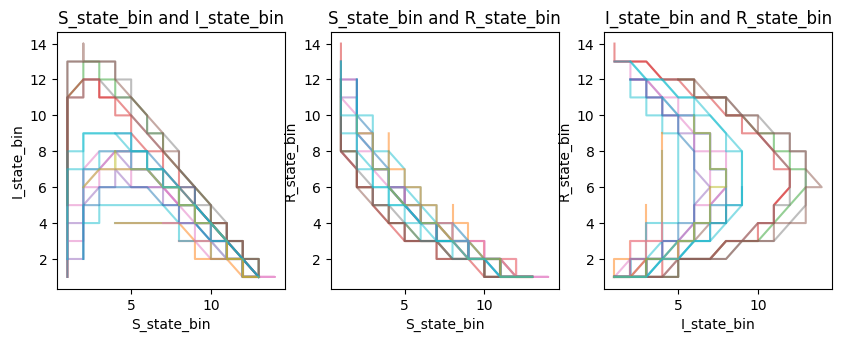

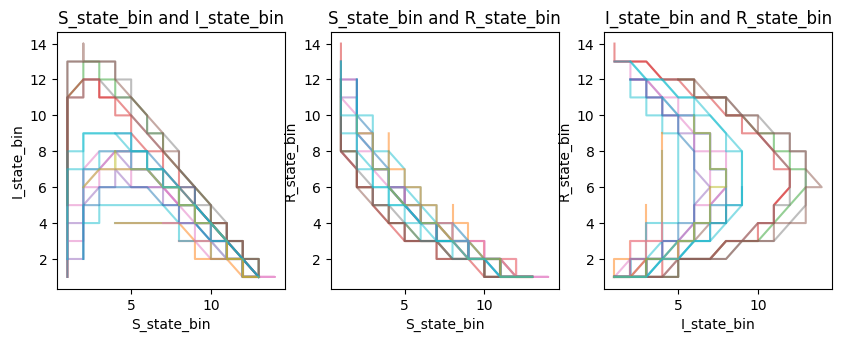

In [ ]:
sir_dataset_output, bin_dict = process_dataset(sir_dataset, bin_outliers = False, log = False)
plot_paths(sir_dataset_output)


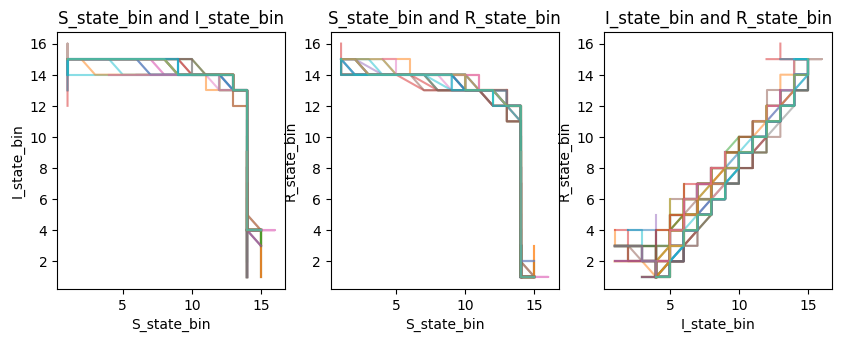

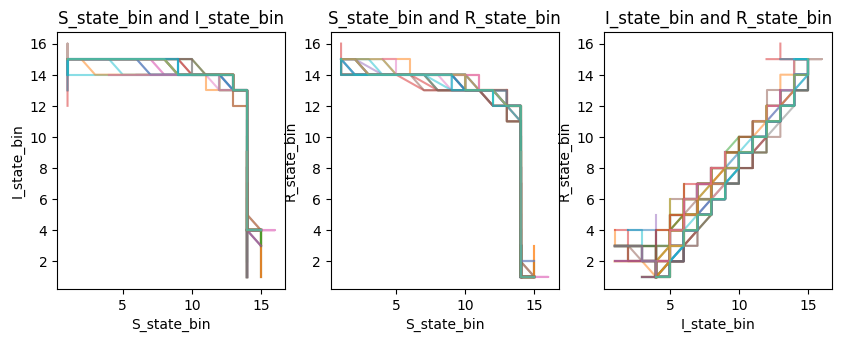

In [ ]:
sir_dataset_output, bin_dict = process_dataset(sir_dataset, bin_outliers = True, log = True)
plot_paths(sir_dataset_output)
